<h1 style="font-size:30px;"><strong>1.Energy Loss Analysis</strong></h1>


**Cell 1: Load data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/processed/solar_features.csv")
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])

df.head()


,DATE_TIME,DC_POWER,AC_POWER,hour,day,month,dayofweek,ac_lag_1,ac_lag_2,ac_lag_24,dc_lag_1,dc_lag_2,dc_lag_24,ac_roll_mean_3,ac_roll_mean_6,dc_roll_mean_3,dc_roll_mean_6
0,2020-05-15 00:15:00,0.0,0.0,0,15,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-15 00:15:00,0.0,0.0,0,15,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-15 00:15:00,0.0,0.0,0,15,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-15 00:15:00,0.0,0.0,0,15,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-15 00:15:00,0.0,0.0,0,15,5,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Cell 2 : Define Expected vs Actual Power**

In [4]:
df["expected_ac_power"] = df["ac_roll_mean_6"]
df["energy_loss"] = df["expected_ac_power"] - df["AC_POWER"]


**Cell 3 : Visualize Loss**

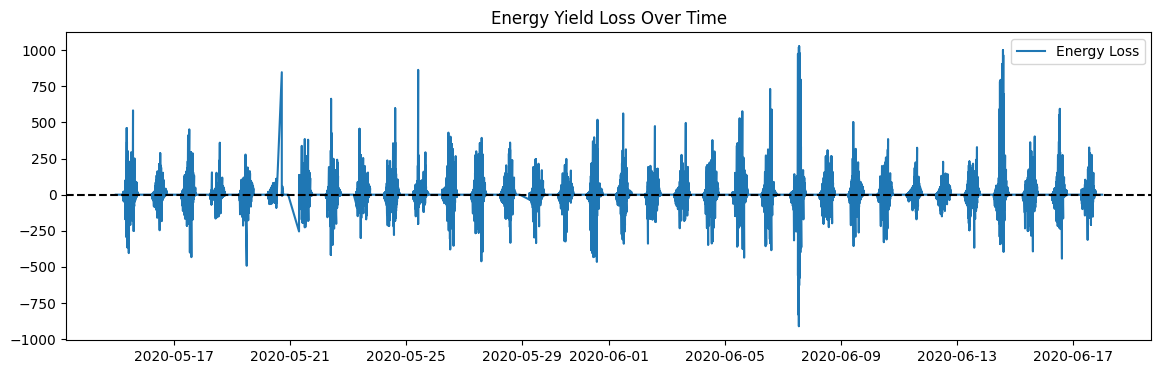

In [6]:
plt.figure(figsize=(14,4))
plt.plot(df["DATE_TIME"], df["energy_loss"], label="Energy Loss")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.title("Energy Yield Loss Over Time")
plt.show()


# **2.Identify Underperforming Periods (Actionable Optimization)**

**Cell 4 : Define “Significant Energy Loss”**

In [8]:
# Define loss threshold (industry heuristic)
LOSS_THRESHOLD = df["energy_loss"].quantile(0.90)

LOSS_THRESHOLD


21.70738091500005

**Cell 5 : Flag Loss Events**

In [10]:
df["high_loss_flag"] = df["energy_loss"] > LOSS_THRESHOLD

df[["DATE_TIME", "AC_POWER", "expected_ac_power", "energy_loss", "high_loss_flag"]].head()


,DATE_TIME,AC_POWER,expected_ac_power,energy_loss,high_loss_flag
0,2020-05-15 00:15:00,0.0,0.0,0.0,False
1,2020-05-15 00:15:00,0.0,0.0,0.0,False
2,2020-05-15 00:15:00,0.0,0.0,0.0,False
3,2020-05-15 00:15:00,0.0,0.0,0.0,False
4,2020-05-15 00:15:00,0.0,0.0,0.0,False


**Cell 6 : Visualize High-Loss Zones**

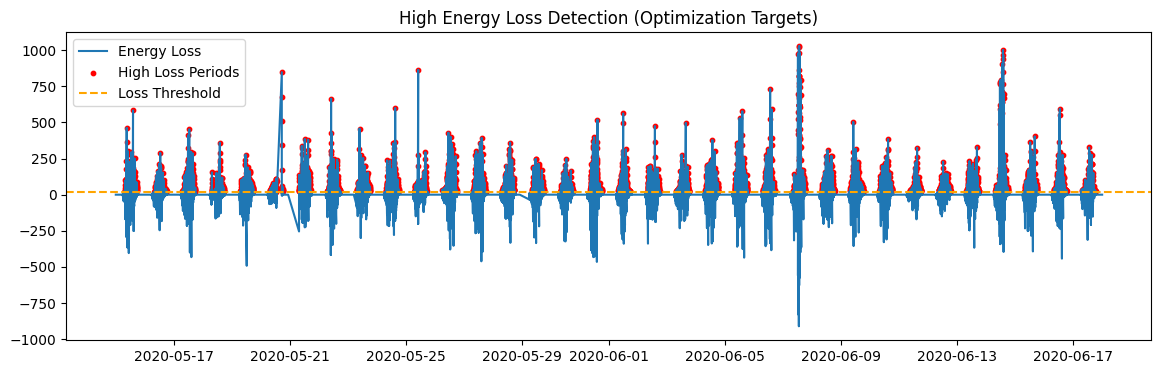

In [12]:
plt.figure(figsize=(14,4))
plt.plot(df["DATE_TIME"], df["energy_loss"], label="Energy Loss")
plt.scatter(
    df.loc[df["high_loss_flag"], "DATE_TIME"],
    df.loc[df["high_loss_flag"], "energy_loss"],
    color="red",
    s=10,
    label="High Loss Periods"
)
plt.axhline(LOSS_THRESHOLD, color="orange", linestyle="--", label="Loss Threshold")
plt.legend()
plt.title("High Energy Loss Detection (Optimization Targets)")
plt.show()


# **3.Convert Energy Loss → Cleaning Recommendation**

**Cell 7 : Detect Persistent Loss (Not Just Spikes)**

In [15]:
# Rolling count of high-loss events (window = 1 day = 96 points for 15-min data)
df["high_loss_rolling"] = (
    df["high_loss_flag"]
    .rolling(window=96)
    .sum()
)


**Cell 8 : Define Cleaning Condition**

In [17]:
# Cleaning rule (industry heuristic)
df["cleaning_required"] = df["high_loss_rolling"] > 20

df[["DATE_TIME", "energy_loss", "cleaning_required"]].tail()


,DATE_TIME,energy_loss,cleaning_required
68059,2020-06-17 23:45:00,0.0,False
68060,2020-06-17 23:45:00,0.0,False
68061,2020-06-17 23:45:00,0.0,False
68062,2020-06-17 23:45:00,0.0,False
68063,2020-06-17 23:45:00,0.0,False


**Cell 9 : Visualize Cleaning Recommendation**

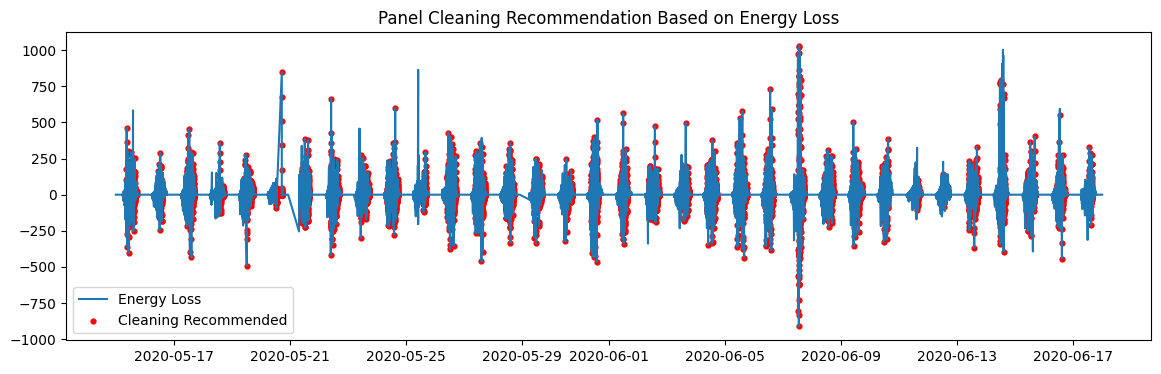

In [18]:
plt.figure(figsize=(14,4))
plt.plot(df["DATE_TIME"], df["energy_loss"], label="Energy Loss")

plt.scatter(
    df.loc[df["cleaning_required"], "DATE_TIME"],
    df.loc[df["cleaning_required"], "energy_loss"],
    color="red",
    s=12,
    label="Cleaning Recommended"
)

plt.legend()
plt.title("Panel Cleaning Recommendation Based on Energy Loss")
plt.show()


# **Bring PdM Result into Phase 3**

**Cell 10 : Bring PdM Result into Phase 3**

In [19]:
# Assume PdM anomaly flag exists (from Phase 2 logic)
# Here we simulate it using rule-based logic for now

df["pdm_fault_flag"] = (
    (df["DC_POWER"] > 3000) & (df["AC_POWER"] < 100)
)


**Cell 11 : Final Optimization Decision**

In [21]:
# Final optimization decision
df["final_cleaning_recommendation"] = (
    df["cleaning_required"] & (~df["pdm_fault_flag"])
)

df[
    ["DATE_TIME", "energy_loss", "cleaning_required", "pdm_fault_flag", "final_cleaning_recommendation"]
].tail()


,DATE_TIME,energy_loss,cleaning_required,pdm_fault_flag,final_cleaning_recommendation
68059,2020-06-17 23:45:00,0.0,False,False,False
68060,2020-06-17 23:45:00,0.0,False,False,False
68061,2020-06-17 23:45:00,0.0,False,False,False
68062,2020-06-17 23:45:00,0.0,False,False,False
68063,2020-06-17 23:45:00,0.0,False,False,False


In [22]:
df["final_cleaning_recommendation"].value_counts()


final_cleaning_recommendation
False    51704
True     16360
Name: count, dtype: int64